---
## Import libraries

In [1]:
import re
import copy
import pickle
import __init__
import numpy as np 
import pandas as pd 
import datetime as dt
import itertools as it
import matplotlib.pyplot as plt 
from __init__ import project_path
from xgboost import XGBRegressor
from sklearn import cross_validation, grid_search
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from data.data_loader import DataLoader

---
## Generate dataset

In [108]:
# ******************
# Load original feature files
# ******************

original_feature_files = ['city_map', 'user_pay', 'holiday_feature', 'weather_feature', 'date_feature']
def load_info(feature_files):
    data = {}
    for feature_file in feature_files:
        data[feature_file] = pickle.load(open(feature_file, 'r+'))
    return data

%time info = load_info(original_feature_files)

CPU times: user 10 s, sys: 518 ms, total: 10.5 s
Wall time: 10.7 s


In [25]:
# ******************
# Concatenate original dateset, including original features and labels as dataframe
# ******************
def dump_original_dataset(info):
    shop_ids = range(1, 2001)
    shop_features = ['shop_id', 'city_name', 'location_id', 'per_pay', 'score', 
                     'comment_cnt', 'shop_level', 'cate_1_name', 'cate_2_name', 'cate_3_name']
    dataset = []
    for shop in shop_ids:
        current_user_pay = info['user_pay'][shop]
        for date in current_user_pay.ordinary_dates:
            if date < '2015-07-01':
                continue
            training_data = []
            base_shop_info = current_user_pay.get_attributes(shop_features)
            if not isinstance(base_shop_info[-1], (basestring, unicode)):
                base_shop_info = base_shop_info[:-1] + [base_shop_info[-2]]
            training_data += base_shop_info
            training_data += [date]
            training_data += info['weather_feature'].get(info['city_map'].get(current_user_pay.city_name, None), {}).get(date, [None]*5)
            training_data += info['date_feature'][date]
            training_data += [current_user_pay.merchant_flow_dict[date]]
            dataset.append(training_data)
    original_dataset = pd.DataFrame(dataset, columns=columns)
    pickle.dump(original_dataset, open('original_dataset', 'w+'))
    return original_dataset

%time original_dataset = dump_original_dataset(info)

CPU times: user 34.7 s, sys: 937 ms, total: 35.6 s
Wall time: 35.8 s


In [101]:
# ******************
# Load original dateset as dataframe
# ******************
%time original_dataset = pickle.load(open('original_dataset', 'r+'))

CPU times: user 28.4 s, sys: 1.54 s, total: 29.9 s
Wall time: 30.7 s


In [113]:
def extract_city_class_feature(x):
    x = info['city_map'][x]
    if x in [u'beijing', u'shanghai', u'guangzhou', u'shenzhen']:
        return 0
    elif x in [u'chengdu', u'hangzhou', u'wuhan', u'tianjin', u'nanjing',
              u'chongqing', u'xian', u'changsha', u'qingdao', u'shenyang',
              u'dalian', u'xiamen', u'suzhou', u'ningbo', u'wuxi']:
        return 1
    elif x in [u'fuzhou', u'hefei', u'zhengzhou', u'haerbin', u'foshan',
              u'jinan', u'dongguan', u'kunming', u'taiyuan', u'nanchang',
              u'nanning', u'wenzhou', u'shijiazhuang', u'changchun', u'quanzhou',
              u'guiyang', u'changzhou', u'zhuhai', u'jinhua', u'yantai',
              u'haikou', u'huizhou', u'wulumuqi', u'xuzhou', u'jiaxing',
              u'weifang', u'luoyang', u'nantong', u'yangzhou', u'shantou']:
        return 2
    else:
        return 3
# http://mt.sohu.com/20160612/n453952071.shtml

counter = 0
for city in list(set(original_dataset['city_name'])):
    if extract_city_class_feature(city) == 3:
        counter += 1
# x = original_dataset['city_name'].apply(extract_city_class_feature)
counter

77

In [117]:
# ******************
# Transfer original dateset to training dataset
# ******************
columns = ['shop_id', 'city_name', 'city_cate_1', 'location_id', 'per_pay', 'score', 
     'comment_cnt', 'shop_level', 'cate_1_name', 'cate_2_name', 
     'cate_3_name', 'date', 'high_temp', 'low_temp', 'rainy', 'wind_direction', 
     'wind_force', 'year_counter', 'month_counter', 'day_counter', 'holiday', 'businessday', 'weekday', 'label']

start_time = dt.datetime.now()

rainy_cate = {
    0: [re.compile('晴'), re.compile('多云'), re.compile('风')],
    1: [re.compile('阴'), re.compile('霾')],
    2: [re.compile('雨')],
    3: [re.compile('雪')]
}
def extract_rainy_feature(x):
    if not x:
        return -1
    temp = [key for key,value in rainy_cate.iteritems() if 
                reduce(lambda a,b:a+b,[re.findall(pattern,x) for pattern in value])]
    if not temp:
        return -1
    return max(temp)

wind_force_cate = {
    0: 3, 
    1: 5,
    2: 6
    }
def extract_wind_force_feature(x):
    pattern = re.compile(r'\d')
    if not x or x<0:
        return 0
    temp = re.findall(pattern, x)
    if not temp:
        return 0
    number = int(max(temp))
    if number <= 3:
        return 0
    elif number <= 5:
        return 1
    else:
        return 2

def extract_temperature_feature(x):
    if x < -20:
        return 0
    elif x < -10:
        return 1
    elif x < 0:
        return 2
    elif x < 10:
        return 3
    elif x < 20:
        return 4
    elif x < 30:
        return 5
    else:
        return 6

def extract_city_class_feature(x):
    x = info['city_map'][x]
    if x in [u'beijing', u'shanghai', u'guangzhou', u'shenzhen']:
        return 0
    elif x in [u'chengdu', u'hangzhou', u'wuhan', u'tianjin', u'nanjing',
              u'chongqing', u'xian', u'changsha', u'qingdao', u'shenyang',
              u'dalian', u'xiamen', u'suzhou', u'ningbo', u'wuxi']:
        return 1
    elif x in [u'fuzhou', u'hefei', u'zhengzhou', u'haerbin', u'foshan',
              u'jinan', u'dongguan', u'kunming', u'taiyuan', u'nanchang',
              u'nanning', u'wenzhou', u'shijiazhuang', u'changchun', u'quanzhou',
              u'guiyang', u'changzhou', u'zhuhai', u'jinhua', u'yantai',
              u'haikou', u'huizhou', u'wulumuqi', u'xuzhou', u'jiaxing',
              u'weifang', u'luoyang', u'nantong', u'yangzhou', u'shantou']:
        return 2
    else:
        return 3
    
dataset = copy.deepcopy(original_dataset)
enumerate_columns = ['city_name', 'cate_1_name', 'cate_2_name', 'cate_3_name', 'wind_force']
enumerate_maps = {}

dataset['rainy'] = dataset['rainy'].apply(extract_rainy_feature)
dataset['wind_force'] = dataset['wind_force'].apply(extract_wind_force_feature)
dataset[['high_temp', 'low_temp']] = dataset[['high_temp', 'low_temp']].applymap(extract_temperature_feature)
dataset['date'] = dataset['date'].apply(lambda x:int(x.replace('-','')))
dataset['city_cate_1'] = dataset['city_name'].apply(extract_city_class_feature)
for column in enumerate_columns:
    enumerate_maps[column] = {value:key for key,value in enumerate(set(dataset[column]))}
    dataset[column] = dataset[column].apply(lambda x:enumerate_maps[column][x])
reduced_columns = [x for x in columns if x not in ['wind_direction']]
dataset = dataset[reduced_columns]
dataset.fillna(value=-1, inplace=True)
dataset = dataset.applymap(int)
pickle.dump(dataset, open('training_set_master', 'w+'))
end_time = dt.datetime.now()
print 'Time consumption is : {}'.format(end_time - start_time)

Time consumption is : 0:00:56.034017


In [120]:
# ******************
# Generate Testing set
# ******************
columns = ['shop_id', 'city_name', 'location_id', 'per_pay', 'score', 
     'comment_cnt', 'shop_level', 'cate_1_name', 'cate_2_name', 
     'cate_3_name', 'date', 'high_temp', 'low_temp', 'rainy', 'wind_direction', 
     'wind_force', 'year_counter', 'month_counter', 'day_counter', 'holiday', 'businessday', 'weekday']

def dump_original_testset(info):
    shop_ids = range(1, 2001)
    testing_date = pd.date_range(start='2016-11-01', end='2016-11-14',freq='D').strftime('%Y-%m-%d').tolist()
    shop_features = ['shop_id', 'city_name', 'location_id', 'per_pay', 'score', 
                     'comment_cnt', 'shop_level', 'cate_1_name', 'cate_2_name', 'cate_3_name']
    dataset = []
    for shop in shop_ids:
        current_user_pay = info['user_pay'][shop]
        for date in testing_date:
            training_data = []
            base_shop_info = current_user_pay.get_attributes(shop_features)
            if not isinstance(base_shop_info[-1], (basestring, unicode)):
                base_shop_info = base_shop_info[:-1] + [base_shop_info[-2]]
            training_data += base_shop_info
            training_data += [date]
            training_data += info['weather_feature'].get(info['city_map'].get(current_user_pay.city_name, None), {}).get(date, [None]*5)
            training_data += info['date_feature'][date]
            dataset.append(training_data)
    original_dataset = pd.DataFrame(dataset, columns=columns)
    pickle.dump(original_dataset, open('original_testset', 'w+'))
    return original_dataset

testing_columns = ['shop_id', 'city_name', 'city_cate_1', 'location_id', 'per_pay', 'score', 
     'comment_cnt', 'shop_level', 'cate_1_name', 'cate_2_name', 
     'cate_3_name', 'date', 'high_temp', 'low_temp', 'rainy', 'wind_direction', 
     'wind_force', 'year_counter', 'month_counter', 'day_counter', 'holiday', 'businessday', 'weekday']
%time dataset = dump_original_testset(info)
start_time = dt.datetime.now()
enumerate_columns = ['city_name', 'cate_1_name', 'cate_2_name', 'cate_3_name', 'wind_force']
enumerate_maps = {}

dataset['rainy'] = dataset['rainy'].apply(extract_rainy_feature)
dataset['wind_force'] = dataset['wind_force'].apply(extract_wind_force_feature)
dataset[['high_temp', 'low_temp']] = dataset[['high_temp', 'low_temp']].applymap(extract_temperature_feature)
dataset['city_cate_1'] = dataset['city_name'].apply(extract_city_class_feature)

for column in enumerate_columns:
    enumerate_maps[column] = {value:key for key,value in enumerate(set(dataset[column]))}
    dataset[column] = dataset[column].apply(lambda x:enumerate_maps[column][x])
reduced_columns = [x for x in testing_columns if x not in ['date', 'wind_direction']]
dataset = dataset[reduced_columns]
dataset.fillna(value=-1, inplace=True)
dataset = dataset.applymap(int)
pickle.dump(dataset, open('testing_set_master', 'w+'))
end_time = dt.datetime.now()
print 'Time consumption is : {}'.format(end_time - start_time)

CPU times: user 1.52 s, sys: 104 ms, total: 1.62 s
Wall time: 1.65 s
Time consumption is : 0:00:02.056122


---
## Feature normalize and extension

In [2]:
# ******************
# Load training dataset, testing set
# ******************
# %time data = pickle.load(open('training_set_3', 'r+'))
%time training_set = pickle.load(open('training_set_master', 'r+'))
%time testing_set = pickle.load(open('testing_set_master', 'r+'))

CPU times: user 2.21 s, sys: 695 ms, total: 2.9 s
Wall time: 2.94 s
CPU times: user 89.6 ms, sys: 29.6 ms, total: 119 ms
Wall time: 124 ms


In [35]:
class Enumerator(object):
    
    def __init__(self, models):
        self.models = models 
        
    def enum(self, orders=1):        
        result = []
        for x in it.product(*[self.models]*orders):
            if len(set(x)) == orders:
                for y in result:
                    if not (set(x)-set(y)):
                        break
                else:
                    result.append(x)
        return result

def expand_dataset(dataset, dump_name=None):
    dummy_features = ['city_cate_1', 'score', 'shop_level', 'cate_1_name', 'high_temp', 'rainy', 'holiday', 'weekday']
    undummied_features = [x for x in dataset.columns if x not in dummy_features]
    enumerator = Enumerator(dummy_features)
    dummies = {}
    for feature in dummy_features:
        dummies[feature] = pd.get_dummies(dataset[feature], prefix=feature)
    feature_combines = enumerator.enum(orders=2)
    cross_feature_set = pd.DataFrame()
    for feature1, feature2 in feature_combines:
        column1 = dummies[feature1].columns[:-1]
        column2 = dummies[feature2].columns[:-1]
        for key in it.product(*[column1, column2]):
            cross_feature_set[key[0]] = dummies[feature1][key[0]]
            cross_feature_set[key[1]] = dummies[feature2][key[1]]
            xor = dummies[feature1][key[0]] ^ dummies[feature2][key[1]]
            mul = dummies[feature1][key[0]] * dummies[feature2][key[1]]
            if len(set(xor)) > 1:
                cross_feature_set['_'.join(key)+'_^'] = xor
            if len(set(mul)) > 1:
                cross_feature_set['_'.join(key)+'_*'] = mul    
    expanded_dataset = pd.concat([dataset[undummied_features], cross_feature_set], axis=1)
    if dump_name:
        pickle.dump(expanded_dataset, open(dump_name, 'w+'))
    return expanded_dataset

%time expanded_training_set = expand_dataset(training_set, 'expanded_training_set_master')
%time expanded_testing_set = expand_dataset(testing_set, 'expanded_testing_set_master')

CPU times: user 1min 53s, sys: 7.73 s, total: 2min
Wall time: 2min 1s
CPU times: user 5.86 s, sys: 304 ms, total: 6.17 s
Wall time: 6.17 s


---
## Training with models

In [2]:
# ******************
# Load training dataset, testing set
# ******************
%time training_set = pickle.load(open('training_set_master', 'r+'))
%time testing_set = pickle.load(open('testing_set_master', 'r+'))
%time expanded_training_set = pickle.load(open('expanded_training_set_master', 'r+'))
%time expanded_testing_set = pickle.load(open('expanded_testing_set_master', 'r+'))

CPU times: user 2.11 s, sys: 671 ms, total: 2.78 s
Wall time: 2.81 s
CPU times: user 96.4 ms, sys: 29 ms, total: 125 ms
Wall time: 130 ms
CPU times: user 12.9 s, sys: 4.05 s, total: 17 s
Wall time: 17.2 s
CPU times: user 519 ms, sys: 165 ms, total: 685 ms
Wall time: 696 ms


In [ ]:
# ******************
# Train with xgboost
# ******************
def eval_metric_expression(y_predicted, y_true):
    eval_value = sum(abs((y_pred - y)/(y_pred + y)))/len(y_pred)
    return 'loss', eval_value

def train_with_xgboost(train, test, expanded=False):
    params = {
        'max_depth': 10,
        'learning_rate': 0.05,
        'n_estimators':2000,
    }
    xgb_model = XGBRegressor(**params)
    start_time = dt.datetime.now()
    columns = list(set(train.columns) & set(test.columns))
    xgb_model.fit(train[columns],train['label'],eval_metric=eval_metric_expression)
    testing_result = xgb_model.predict(test[columns])
    result = {}
    for shop_id in range(1,2001):
        result[shop_id] = map(lambda x:int(x), testing_result[(shop_id-1)*14:shop_id*14].tolist())
    if expanded:
        pickle.dump(result, open('result_with_xgboost_expanded_' + params.__repr__().replace("'",''), 'w+'))
    else:
        pickle.dump(result, open('result_with_xgboost_' + params.__repr__().replace("'",''), 'w+'))
    end_time = dt.datetime.now()
    print '训练耗时：{}'.format(end_time - start_time)
    return xgb_model, result 

xgb_model, result = train_with_xgboost(expanded_training_set, expanded_testing_set, expanded=True)

In [49]:
xgb_model.score

<bound method XGBRegressor.score of XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [172]:
# ******************
# generate prediction file
# ******************
master_file_name = 'result_with_xgboost_' + params.__repr__().replace("'",'')
pred_master = pickle.load(open(master_file_name, 'r+'))
pred_benchmark = pickle.load(open('result_benchmark', 'r+'))
pred_result = []
master_weight, benchmark_weight = 3.5, 6.5
for shop_id in range(1, 2001):
    current_pred_master = np.array(pred_master[shop_id])
    current_pred_benchmark = np.array(pred_benchmark[shop_id])
    result = master_weight*current_pred_master + benchmark_weight*current_pred_benchmark
    result = map(lambda x:int(x/10), result.tolist())
    if min(result) <=0:
        result = map(lambda x:x+abs(min(result))+5, result)
    pred_result.append([shop_id]+result)

pd.DataFrame(pred_result).to_csv(master_file_name+ '_m_{}_b_{}.csv'.format(master_weight, benchmark_weight), header=False, index=False)

In [178]:
# ******************
# Cross validation
# ****************** 
@make_scorer
def scorer(y, y_pred, **kwargs):
    return sum(abs((y_pred - y)/(y_pred + y)))/len(y_pred)

# eval_metric demo : http://www.tuicool.com/articles/FNzI3aZ
def eval_metric_expression(y_predicted, y_true):
    eval_value = sum(abs((y_pred - y)/(y_pred + y)))/len(y_pred)
    return 'loss', eval_value
    
model = XGBRegressor()
param_grid = [
    {'max_depth': [14], 'n_estimators': [2000], 'learning_rate':[0.05]},
]
xgb_model = grid_search.GridSearchCV(model, param_grid, cv = 5, scoring=scorer)

start_time = dt.datetime.now()
best_models = dict()
training_set = data.loc[:,map(lambda x:True if x != 'date' else False, data.columns.tolist())]
xgb_model.fit(training_set.iloc[:,:-1],training_set.iloc[:,-1])
scores = xgb_model.grid_scores_
sorted_index = sorted(np.arange(0, len(scores)), key = lambda x:scores[x].mean_validation_score, reverse = False)
best_model_index = sorted_index[0]
best_model = {
        'model': scores[best_model_index].parameters,
        'mean_loss': scores[best_model_index].mean_validation_score,
         'cvScores': [score for score in scores[best_model_index].cv_validation_scores]
}
end_time = dt.datetime.now()
print '耗时：{}'.format(end_time - start_time)

耗时：2:04:17.717358


In [198]:
scores

[mean: 0.24447, std: 0.01554, params: {'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 18}]

---
## Result exhibition

In [152]:
# ******************
# Get history data
# ****************** 
%time history_data = pickle.load(open(project_path + '/data/user_pay', 'r+'))

In [164]:
# ******************
# Load predictions
# ****************** 
prediction_master = pickle.load(open('result_with_xgboost_{n_estimators: 2000, learning_rate: 0.05, max_depth: 10}','r+'))
prediction_comparison = pickle.load(open('result_with_xgboost_16_2000_0.05', 'r+'))
prediction_benchmark = pickle.load(open('result_benchmark', 'r+'))

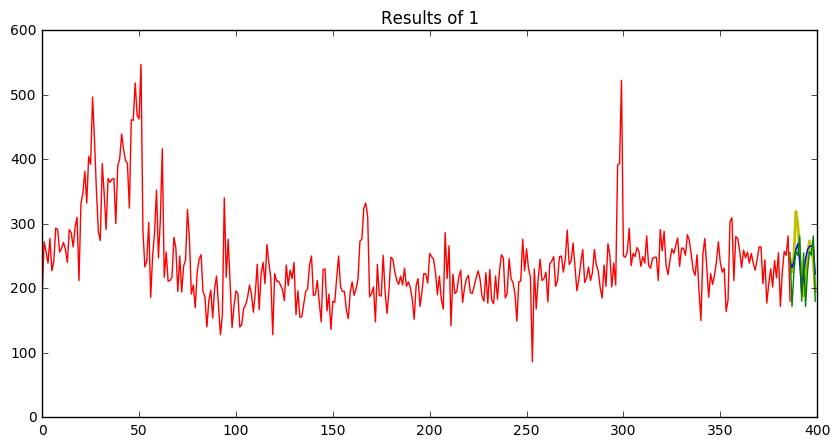

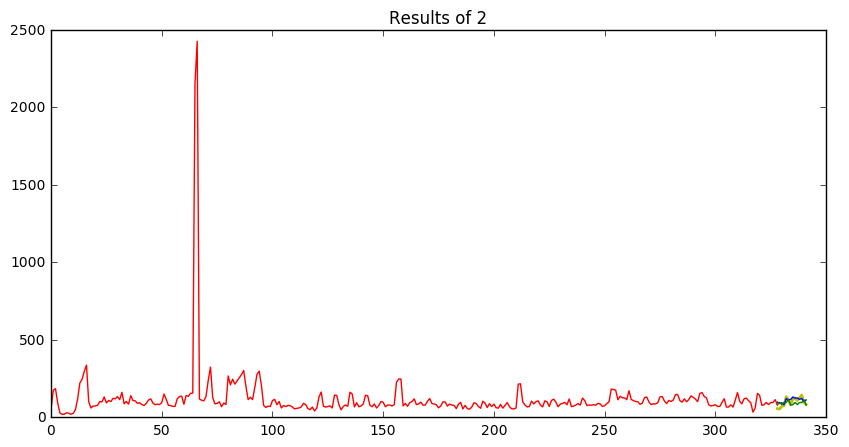

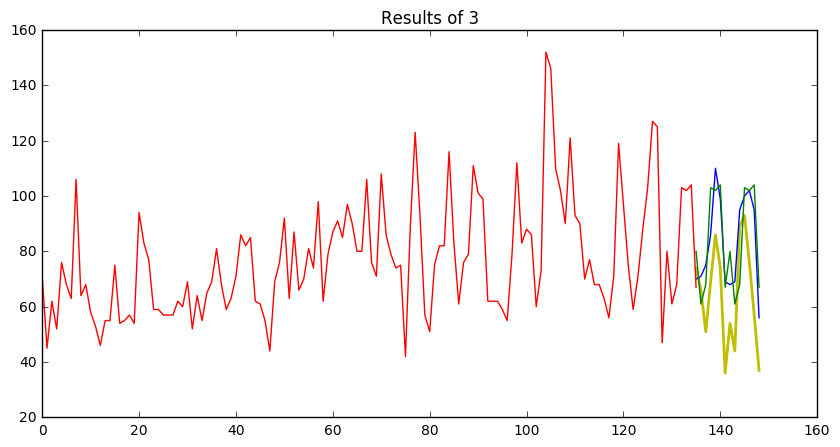

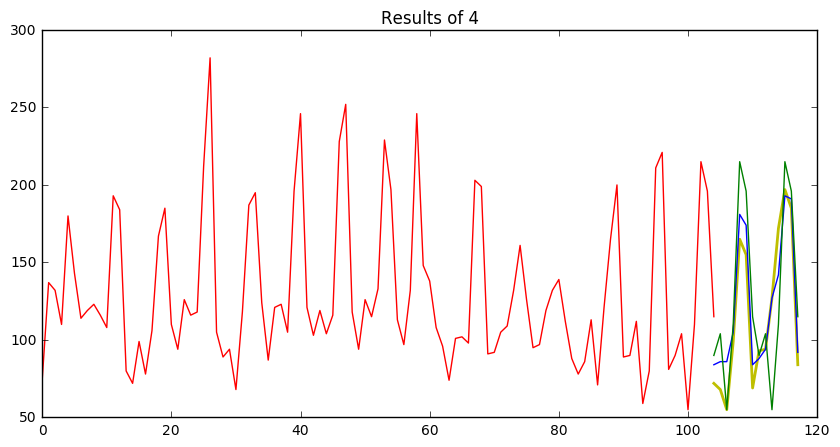

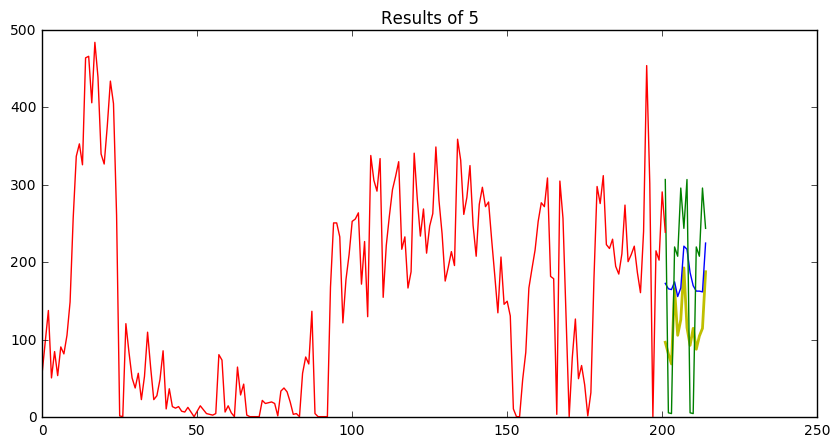

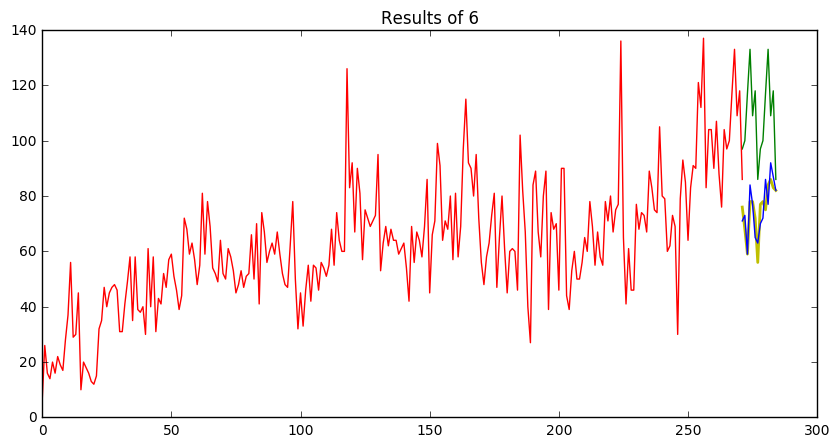

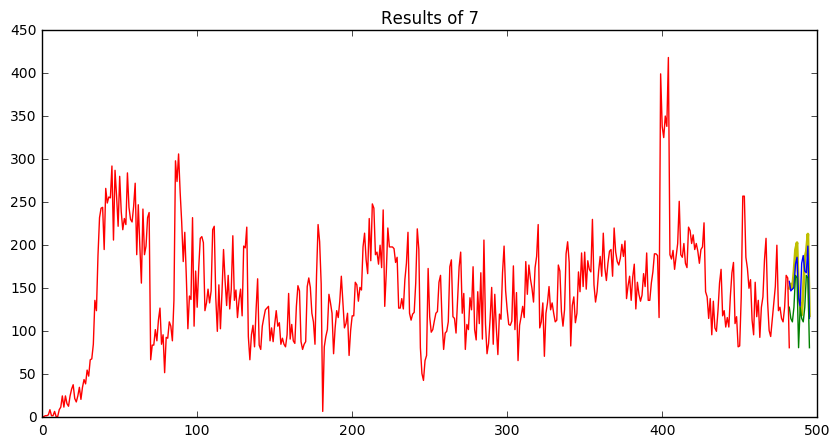

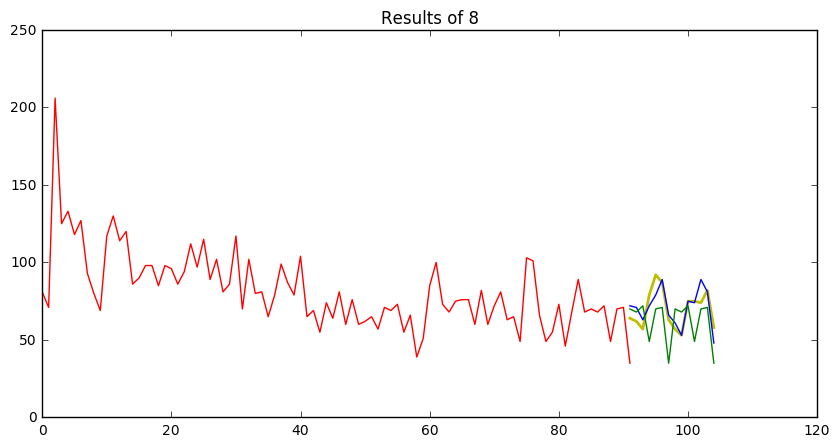

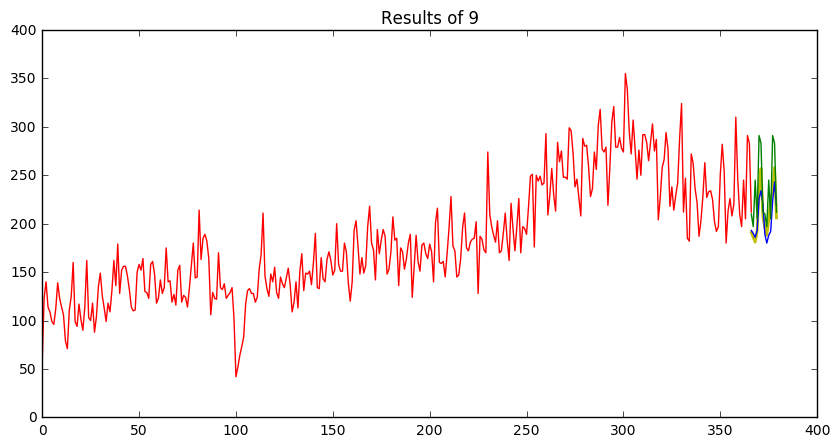

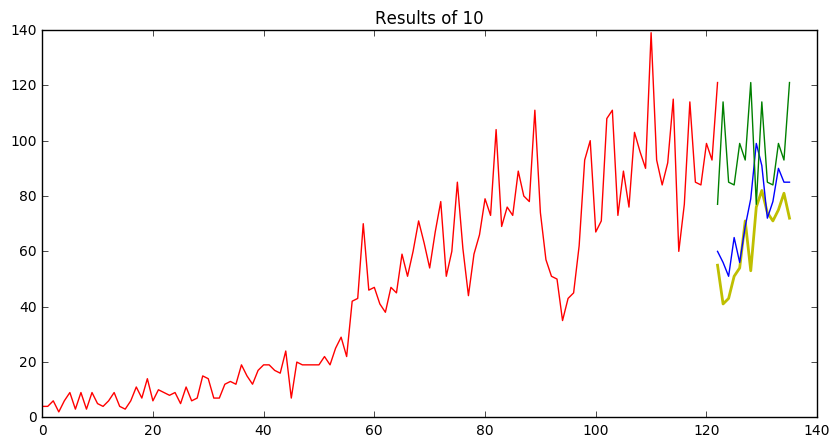

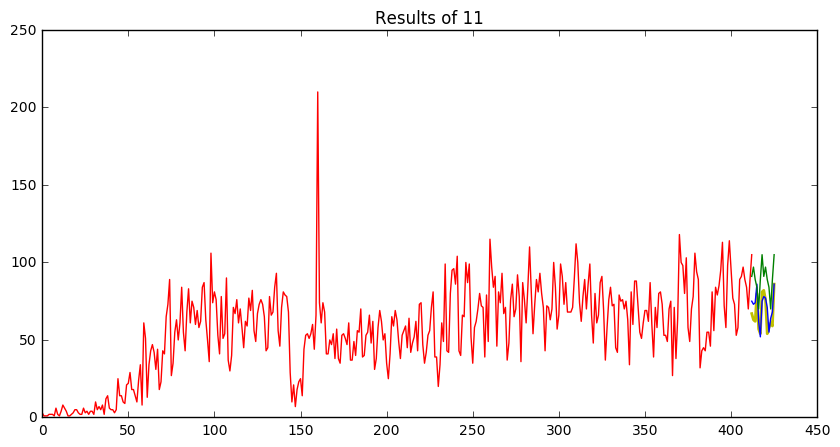

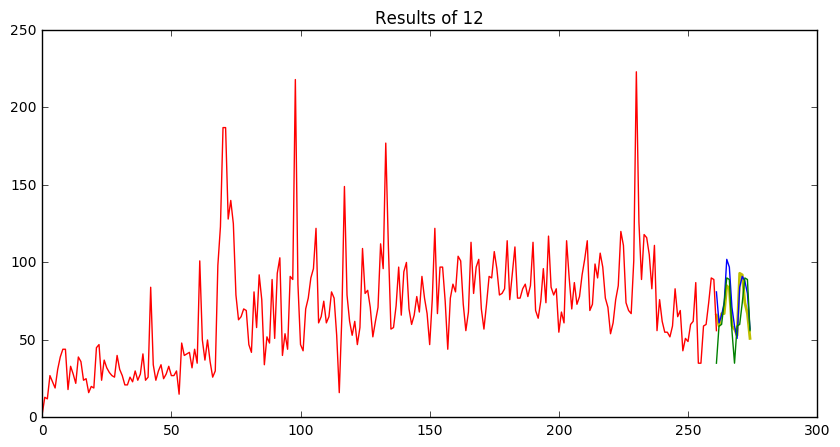

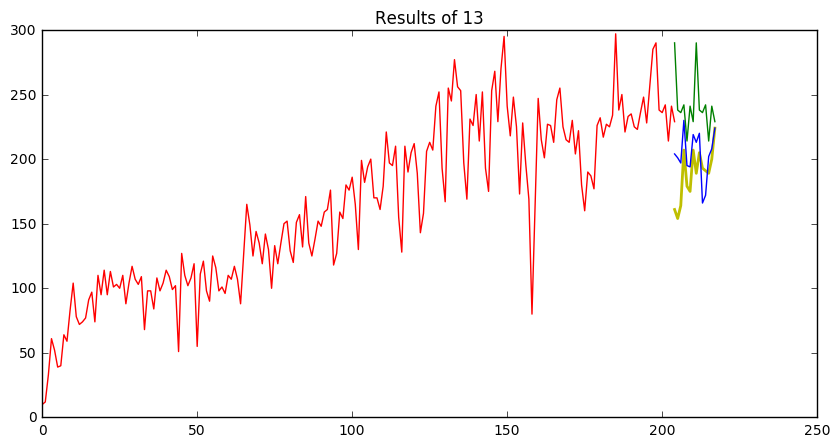

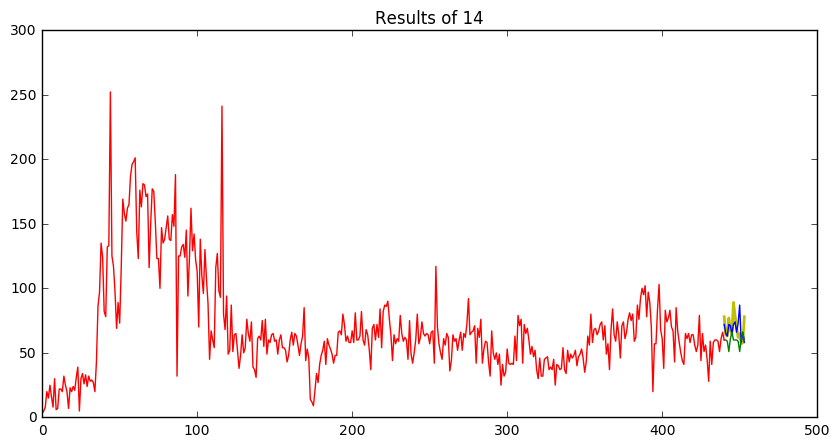

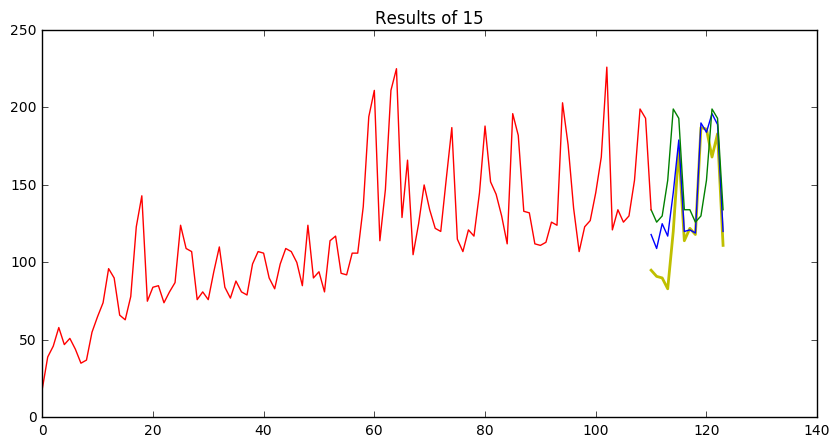

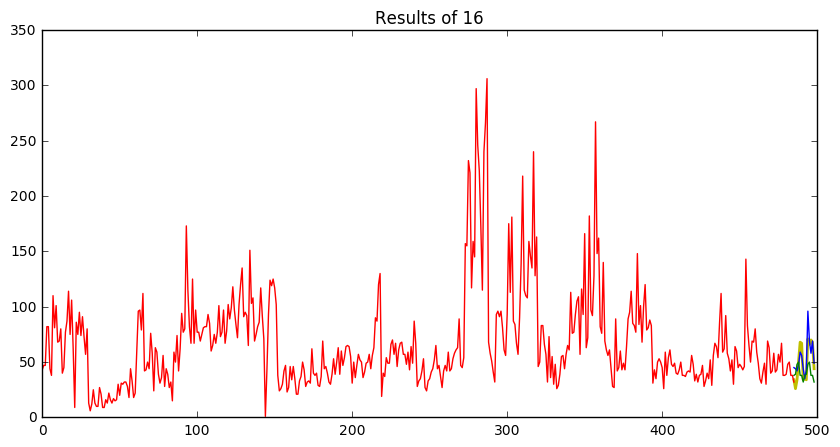

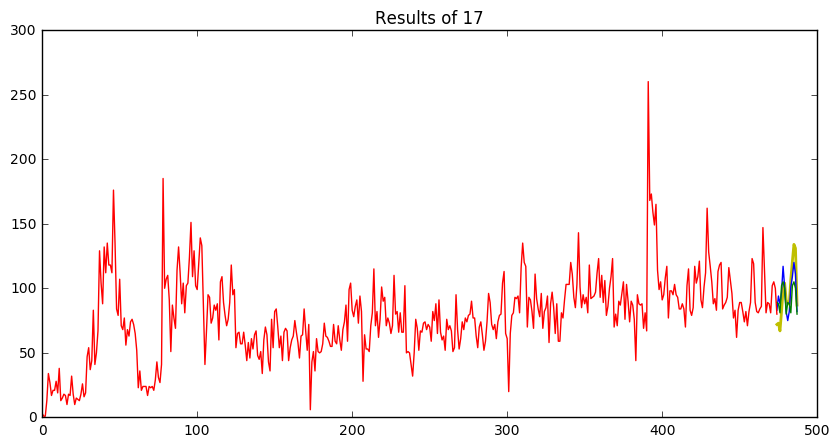

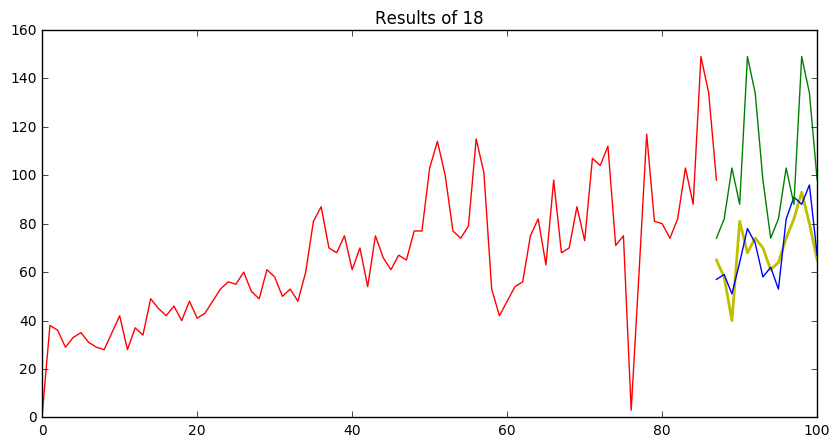

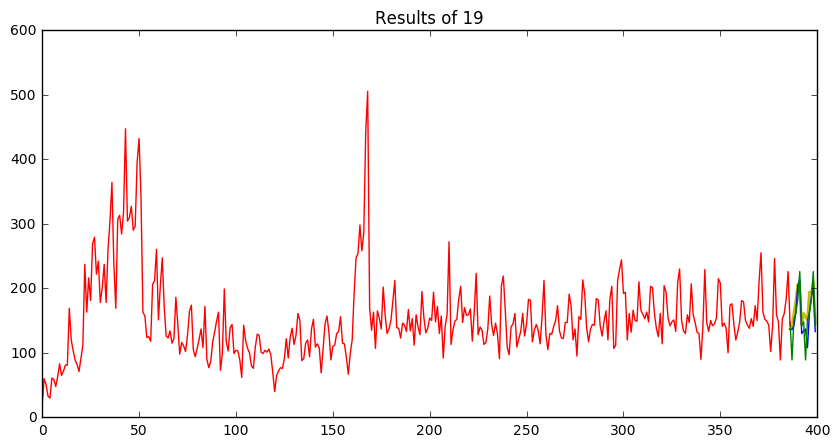

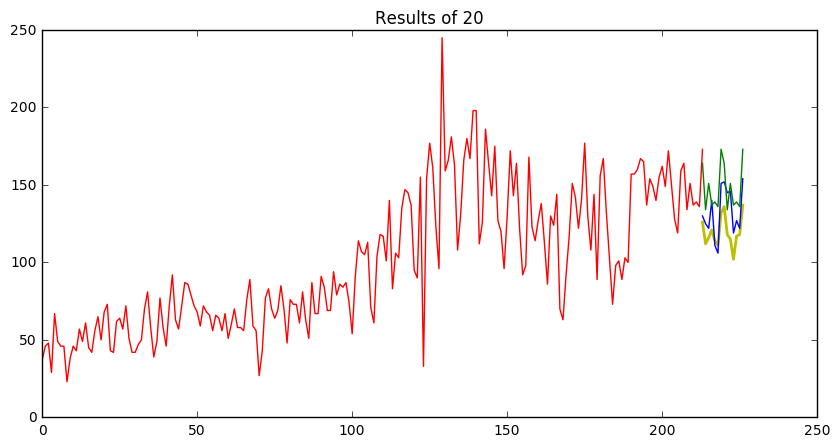

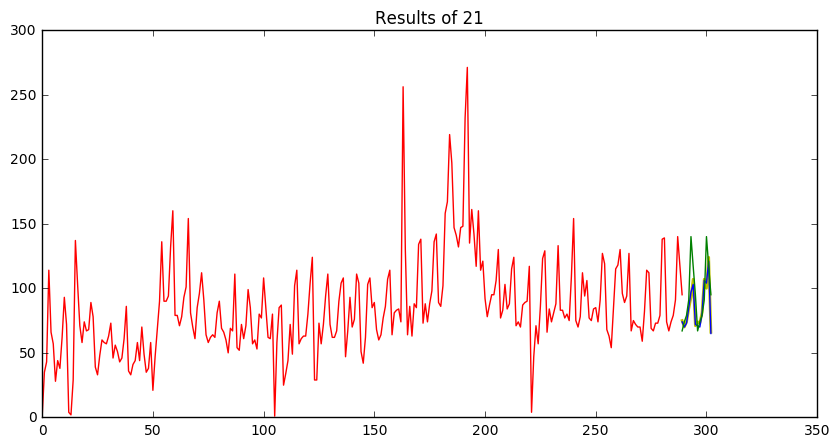

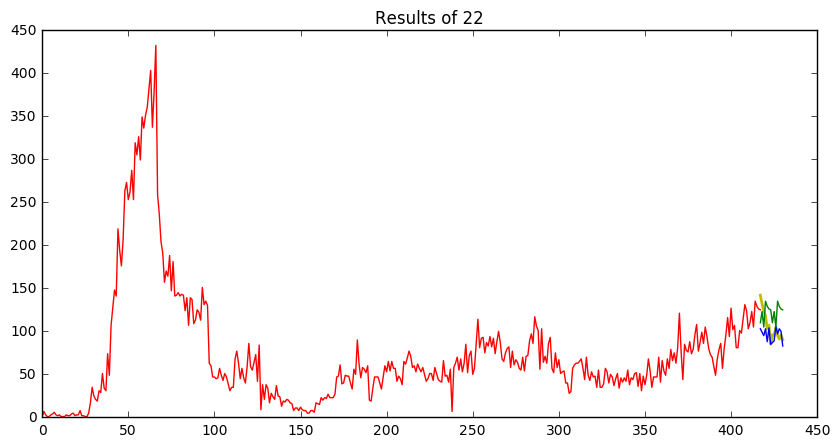

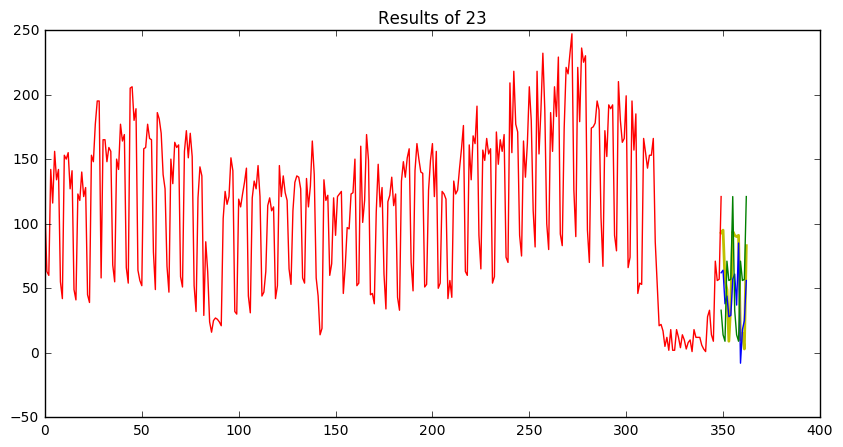

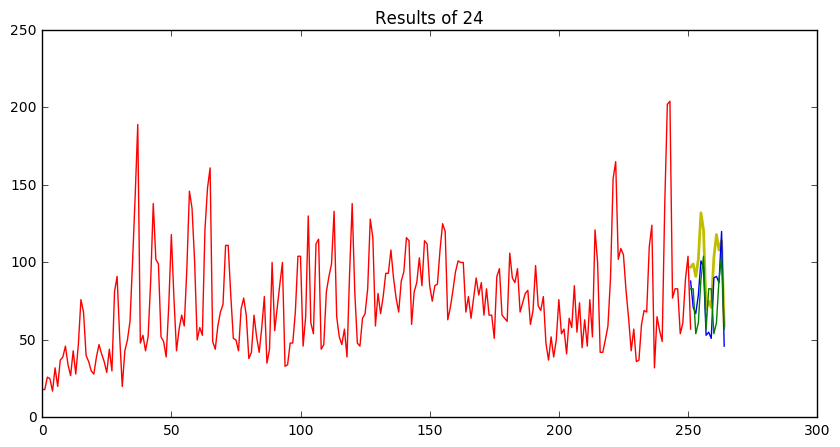

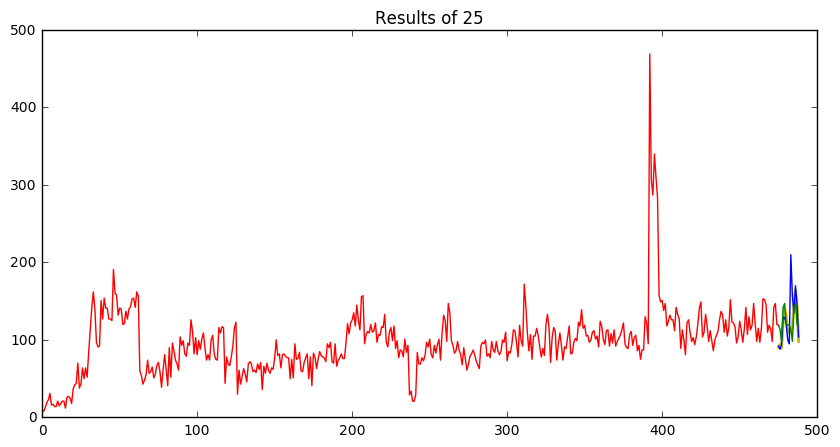

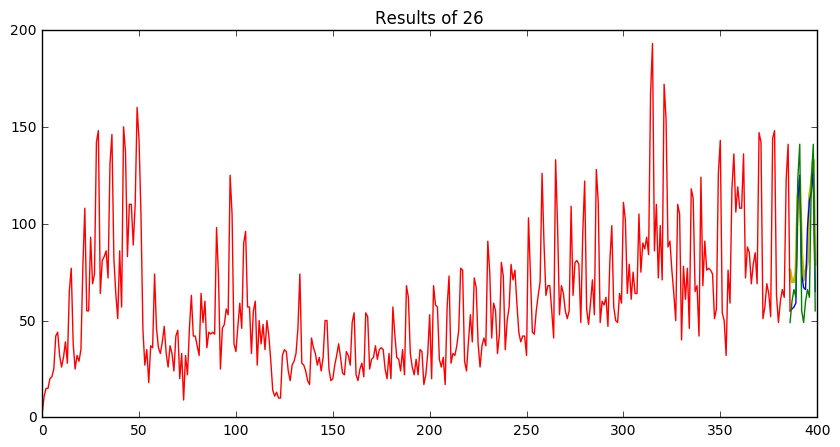

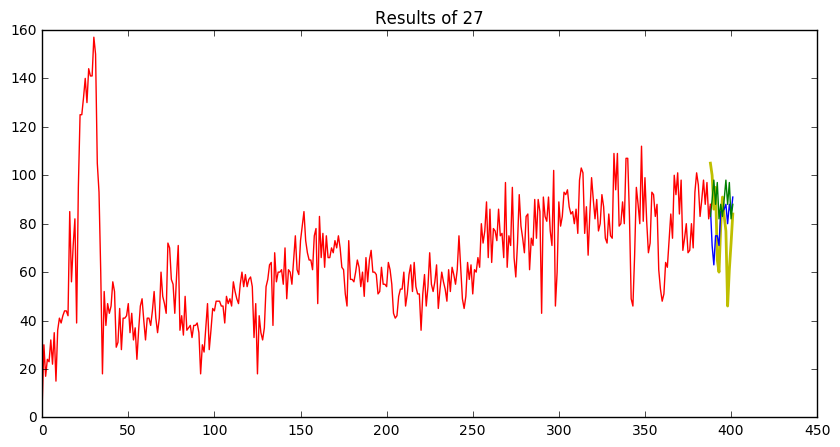

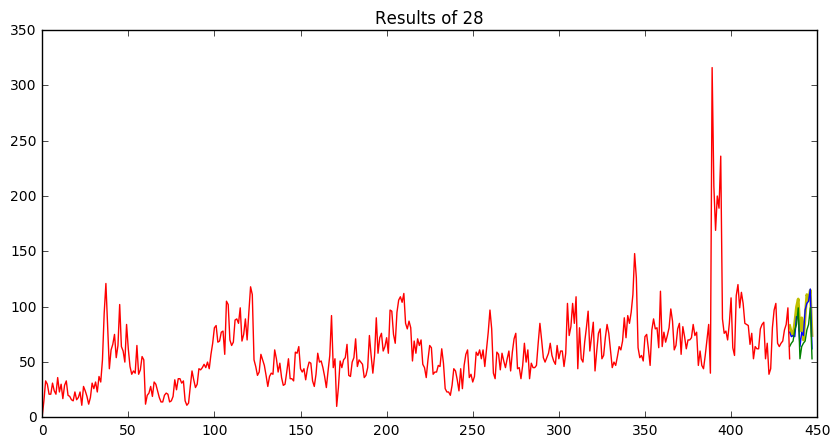

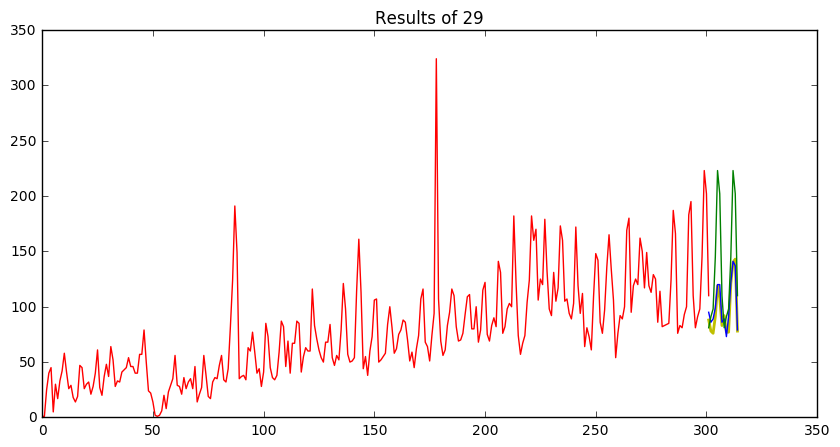

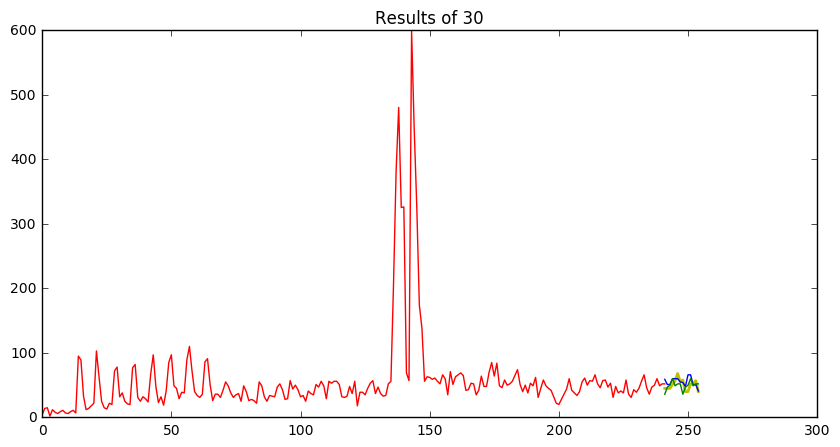

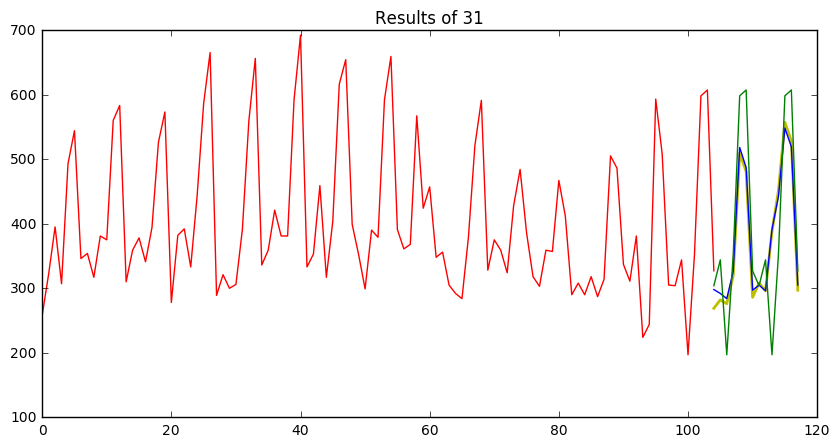

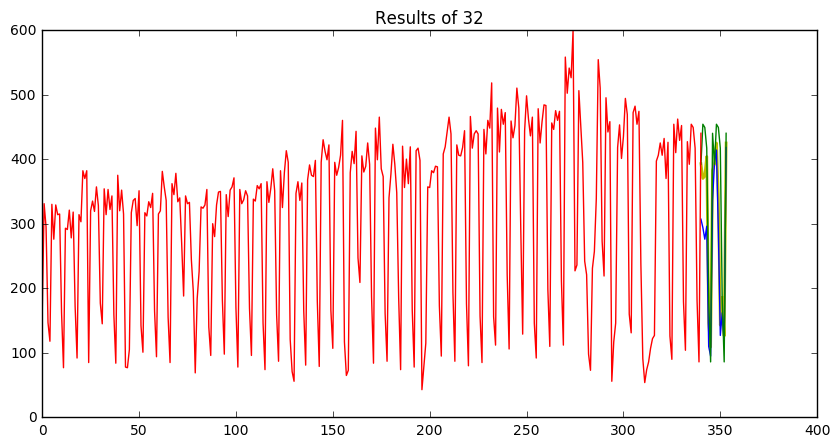

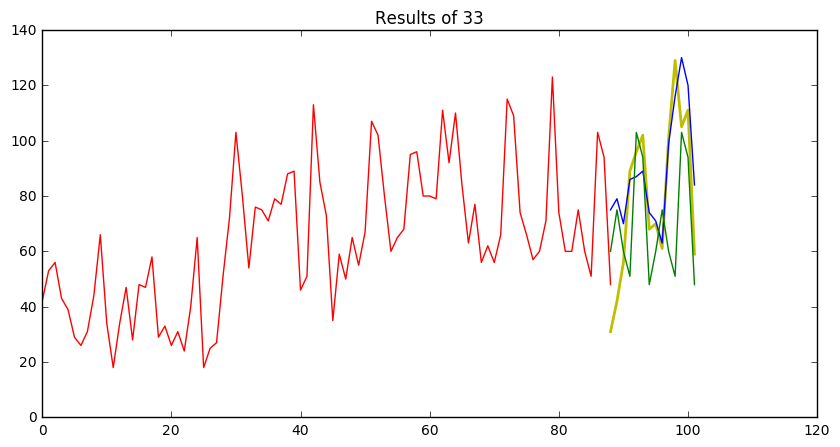

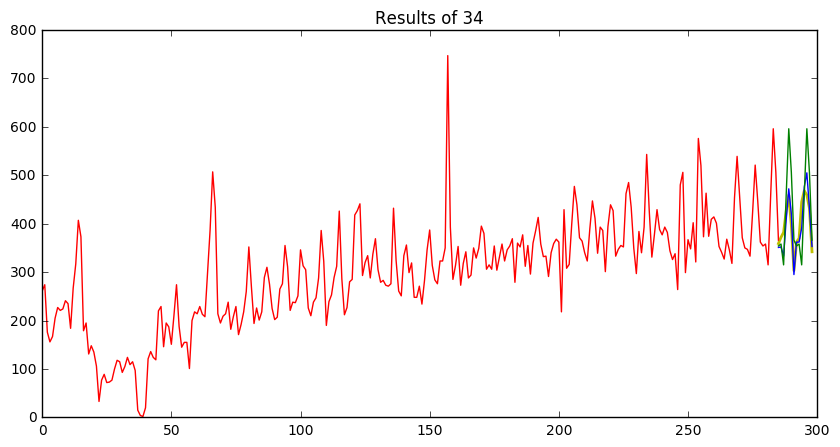

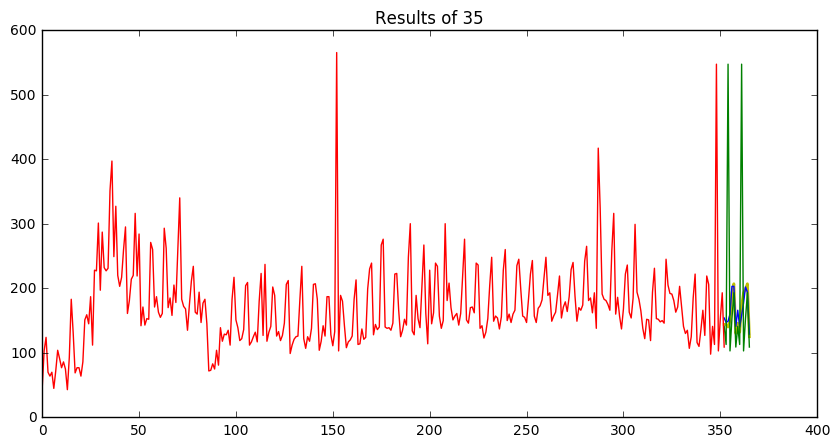

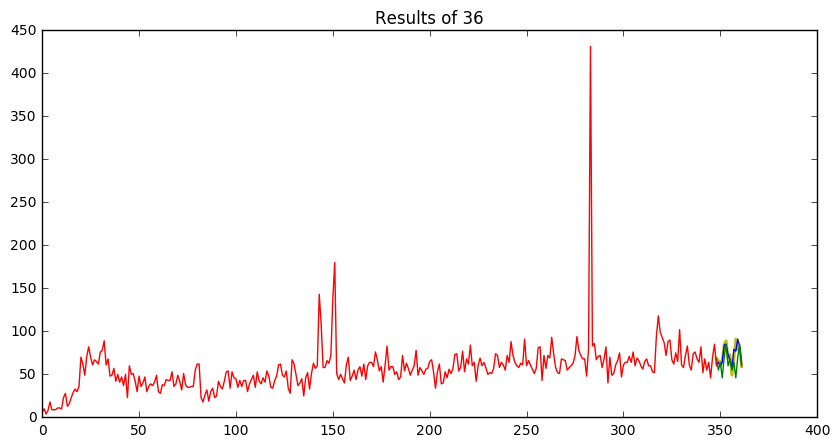

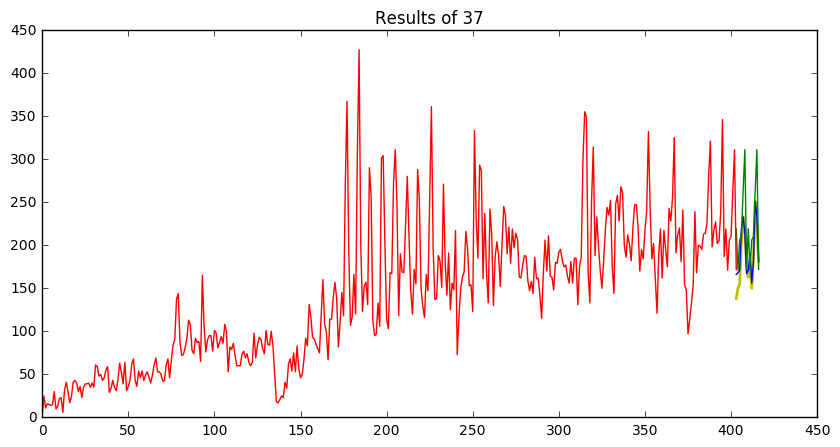

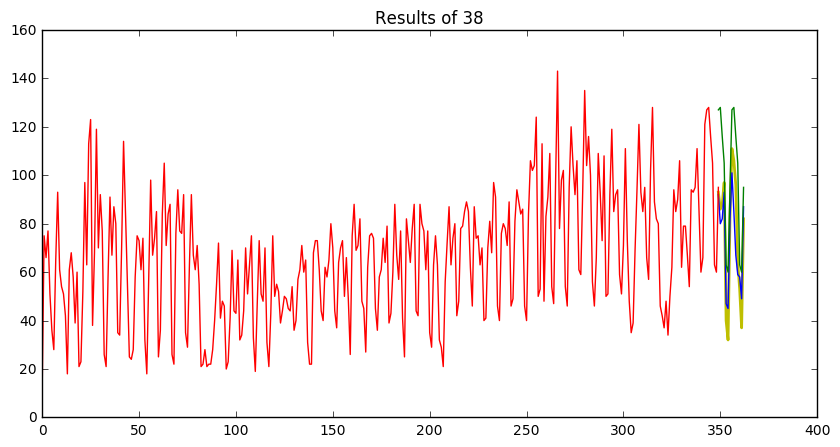

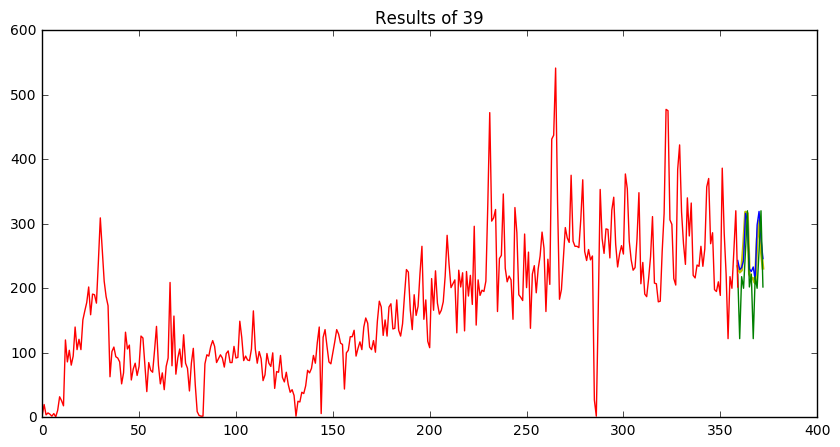

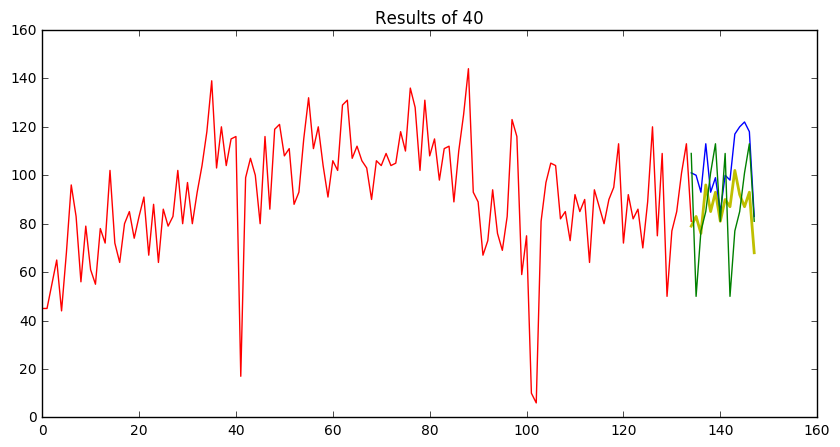

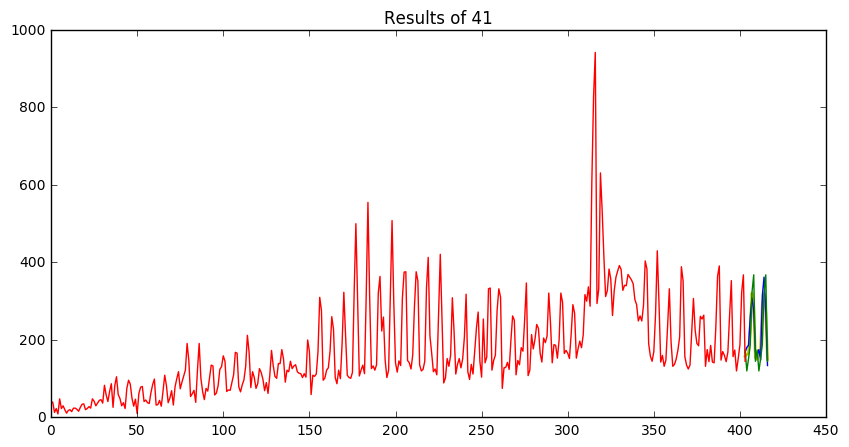

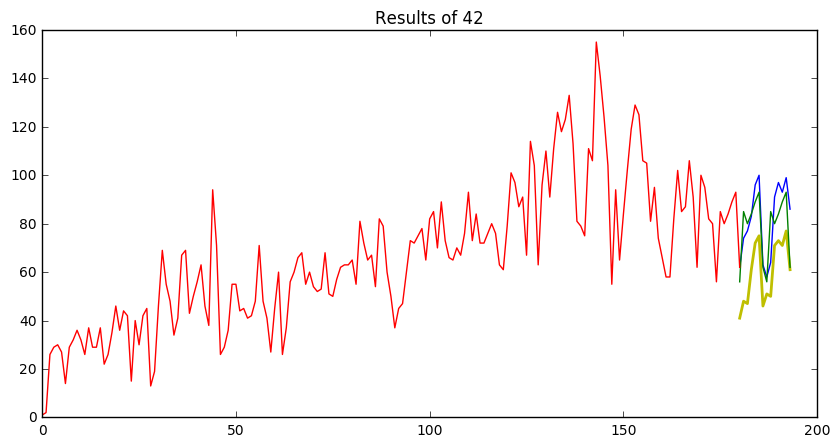

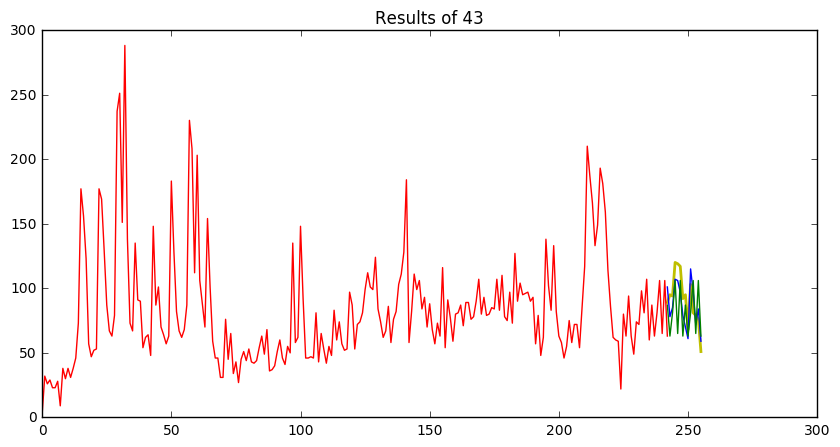

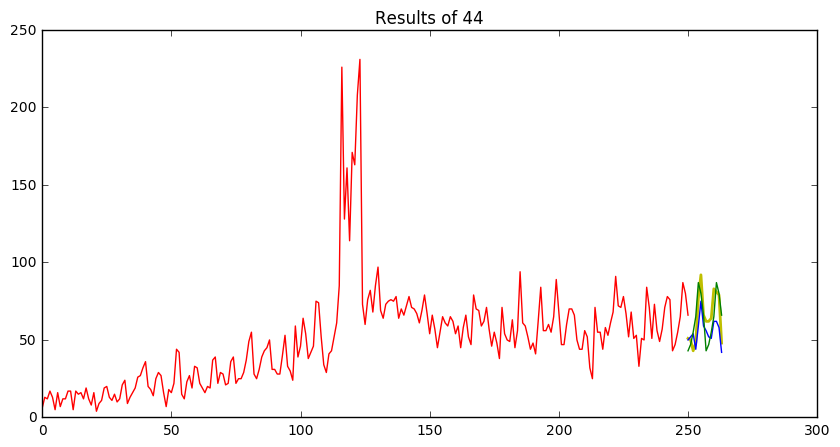

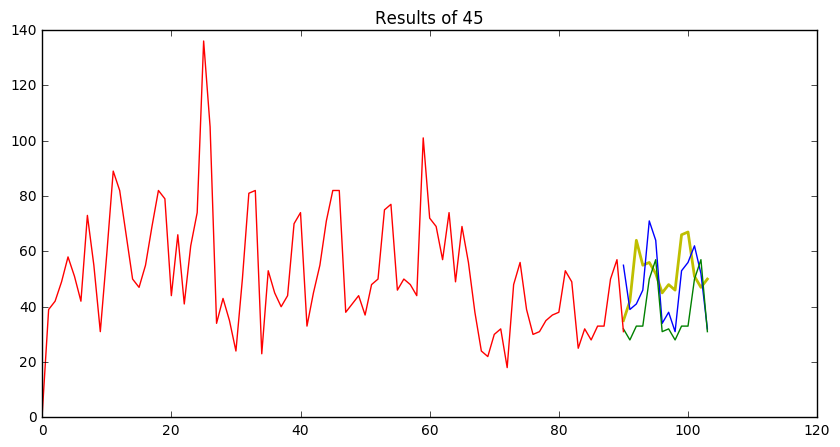

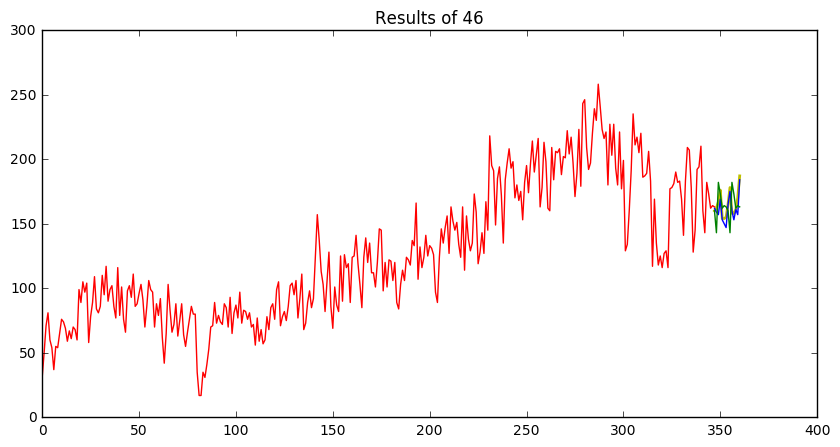

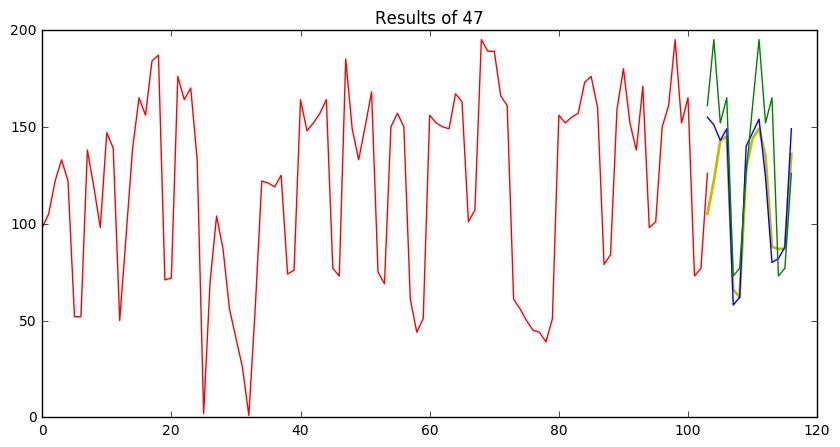

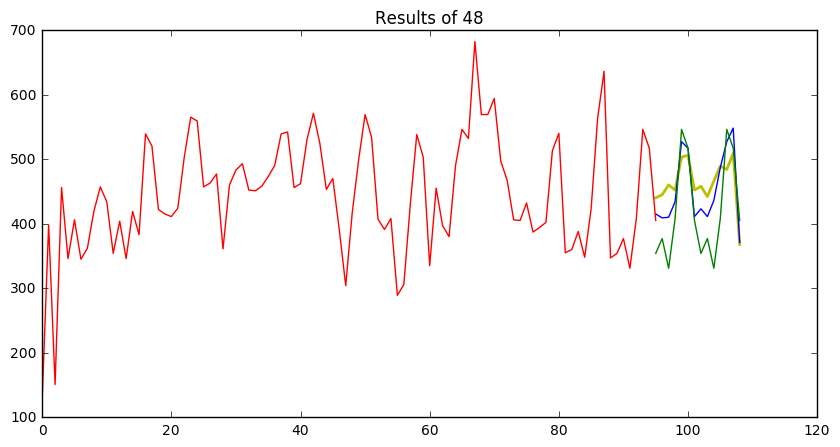

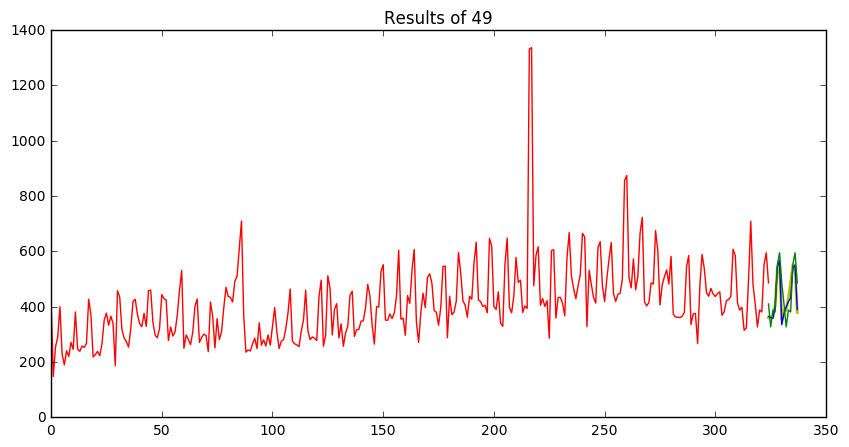

In [165]:
# ******************
# plot some results
# ****************** 
for shop_id in range(1, 50):
    figure = plt.figure(figsize=(10,5))
    pred_master = prediction_master[shop_id]
    pred_comparison = prediction_comparison[shop_id]
    pred_benchmark = prediction_benchmark[shop_id]
    history = history_data[shop_id].merchant_flow
    plt.plot(range(len(history)-1, len(history)-1+len(pred_master)),pred_master, 'y', linewidth=2)
    plt.plot(range(len(history)-1, len(history)-1+len(pred_comparison)),pred_comparison, 'b')
    plt.plot(range(len(history)-1, len(history)-1+len(pred_benchmark)),pred_benchmark, 'g')
    plt.plot(range(len(history)), history, 'r')
    plt.title('Results of {}'.format(shop_id))
    plt.show()